In [1]:
import pandas as pd

pd.set_option("display.precision", 3)
import os
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import sys
import math
import seaborn as sns

sns.set_style("white")
import scipy.stats as sps
import copy
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.lines as mlines
from pathlib import Path
from random import shuffle
import scipy.stats as stats

# Physio 

In [2]:
columns = [
    "temp.high",
    "temp.low",
    "rr.high",
    "sato2.low",
    "hr.high",
    "cap.refill",
    "sbp.low",
    "map.low",
    "gcs.low",
    "fio2.high",
    "wcc.high",
    "wcc.low",
    "anc.low",
    "lymph.low",
    "platelets.low",
    "paco2.high",
    "pao2.low",
    "lactate.high",
    "bili.high",
    "crea.high",
    "inr.high",
    "alat.high",
    "age.at.bc",
    "ccc.summary",
    "psofa.resp",
    "psofa.cvs",
    "psofa.cns",
    "psofa.ren",
    "psofa.hep",
    "psofa.hem",
]


configs = [
    ["clinical", 4, "DBSCAN"],
    ["contextual", 6, "DBSCAN"],
    ["physio", 4, "ConsensusKMeans"],
    ["proteome", 5, "DBSCAN"],
]

In [3]:
data_path = "data/"
kcc_path = '{}/KCC/'.format(data_path)
score_path = "{}/ClusteringResults/".format(data_path)
cdf_path = "{}/CDF plots/".format(data_path)
Hierachical_plot_path = "{}/Hierachical_plots/".format(data_path)

refer_id = pd.read_csv("data/ContextualViewStandardized.csv", index_col=0).index
physio_view = pd.read_csv("data/PhysioViewNormalImputed.csv", index_col=0)

contextual_view = pd.read_csv("data/ContextualViewZeroImputed.csv", index_col=0)
clinical_view = pd.concat([physio_view, contextual_view], 1)
clinical_view = clinical_view.loc[
    :,
    ~clinical_view.columns.isin(
        ["pupils", "crp.high", "neonate", "abx.change.cfz", "abx.change.ery"]
    ),
]
proteome_view = pd.read_csv("data/ProteomeViewMICEimputed_UniProt.csv", index_col=0)
clinical_view = clinical_view[columns]
clinical_view = clinical_view[clinical_view.index.isin(refer_id)]
sc = StandardScaler()
proteome_view[proteome_view.columns] = sc.fit_transform(proteome_view.values)

In [41]:


def plot_diff(diff1, diff2, c1, c2, name, view):
    plt.figure(figsize=(16, 9))
    plt.plot(diff1, color='r', label='cluster {}'.format(c1))
    plt.plot(diff2, color='b', label='cluster {}'.format(c2))
    plt.xticks(range(len(diff1)), diff1.index,  rotation=90,fontsize=15)
    plt.title('{}, cluster {} vs {}'.format(view.upper(), c1, c2))
    plt.legend()
    #plt.ylim(-1.5, 1.)
    plt.axhline(0, color='black', lw=2, linestyle='dashed',)
    plt.tight_layout()
    plt.savefig('data/MeanStandardDiff_plots/{}'.format(name), dpi=200)
    plt.close()

In [13]:
for i in range(len(configs)):
    view, KCC_space, method = configs[i]

    assignments = pd.read_csv(
        "{}/{}_{}_view_KCC_{}_assignments_ranked.csv".format(
            score_path, method, view, KCC_space
        ),
        index_col=0,
    )
    if method == 'DBSCAN':
        assignments["assignment"] = assignments["assignment"] + 1
        assignments = assignments[assignments["assignment"] != 0]
    num_cluster = len(np.unique(assignments["assignment"].tolist()))


    clinical_view["assignment"] = assignments["assignment"]
    clinical_view = clinical_view[clinical_view["assignment"].notnull()]
    
    
    for c1 in clinical_view["assignment"].unique():
        
        data_ovr = clinical_view.copy()
        c1 = int(c1)
        c2 = 'R'
        
        data_ovr.loc[data_ovr[data_ovr['assignment'] != c1].index, 'assignment'] = c2

        diff1 = (
            data_ovr[(data_ovr["assignment"] == c1)]
            .drop("assignment", 1)
            .mean()
            - data_ovr.mean()
        )
        diff2 = (
            data_ovr[(data_ovr["assignment"] == 'R')]
            .drop("assignment", 1)
            .mean()
            - data_ovr.mean()
        )

        diff1 = diff1.sort_values()
        diff2 = diff2[diff1.index]

        savename = "{}, cluster {} vs {}.png".format(view.upper(), c1, c2)
        plot_diff(diff1, diff2, c1, c2, savename, view)

In [14]:
assignments = pd.read_csv(
        "{}/MVKDR_results/proteome_clinical_K_4_assignments_ranked.csv".format(data_path),
        index_col=0,
    )

num_cluster = len(np.unique(assignments["assignment"].tolist()))

clinical_view = clinical_view[columns]
clinical_view = clinical_view[clinical_view.index.isin(refer_id)]
clinical_view["assignment"] = assignments["assignment"]
clinical_view = clinical_view[clinical_view["assignment"].notnull()]
for c1 in clinical_view["assignment"].unique():
        
    data_ovr = clinical_view.copy()
    c1 = int(c1)
    c2 = 'R'

    data_ovr.loc[data_ovr[data_ovr['assignment'] != c1].index, 'assignment'] = c2

    diff1 = (
        data_ovr[(data_ovr["assignment"] == c1)]
        .drop("assignment", 1)
        .mean()
        - data_ovr.mean()
    )
    diff2 = (
        data_ovr[(data_ovr["assignment"] == 'R')]
        .drop("assignment", 1)
        .mean()
        - data_ovr.mean()
    )

    diff1 = diff1.sort_values()
    diff2 = diff2[diff1.index]

    savename = "{} physio, cluster {} vs {}.png".format('MV', c1, c2)
    plot_diff(diff1, diff2, c1, c2, savename, 'MV')
    
    

# proteome

In [4]:
assignments = pd.read_csv(
        "{}/MVKDR_results/proteome_clinical_K_4_assignments_ranked.csv".format(data_path),
        index_col=0,
    )

num_cluster = len(np.unique(assignments["assignment"].tolist()))

proteome_view = proteome_view[proteome_view.index.isin(refer_id)]
proteome_view["assignment"] = assignments["assignment"]
proteome_view = proteome_view[proteome_view["assignment"].notnull()]

In [50]:
def plot_diff(diff1, diff2, c1, c2, name, view):
    plt.figure(figsize=(16, 9))
    plt.plot(diff1.tolist(), color='r', label='cluster {}'.format(c1))
    plt.plot(diff2.tolist(), color='b', label='cluster {}'.format(c2))
    #plt.xticks(range(len(diff1)), diff1.index,  rotation=90,fontsize=15)
    plt.title('{}, cluster {} vs {}'.format(view.upper(), c1, c2))
    plt.legend()
    plt.axhline(0, color='black', lw=2, linestyle='dashed',)
    plt.tight_layout()
    plt.savefig('data/MeanStandardDiff_plots/{}'.format(name), dpi=200)
    plt.close()

In [5]:
for c1 in proteome_view["assignment"].unique():
    data_ovr = proteome_view.copy()
    c1 = int(c1)
    c2 = 'R'

    data_ovr.loc[data_ovr[data_ovr['assignment'] != c1].index, 'assignment'] = c2

    diff1 = (
        data_ovr[(data_ovr["assignment"] == c1)]
        .drop("assignment", 1)
        .mean()
        - data_ovr.mean()
    )
    diff2 = (
        data_ovr[(data_ovr["assignment"] == 'R')]
        .drop("assignment", 1)
        .mean()
        - data_ovr.mean()
    )

    diff1 = diff1.sort_values()
    diff2 = diff2[diff1.index]

    savename = "{} proteome, cluster {} vs {}.png".format('MV', c1, c2)
    plot_diff(diff1, diff2, c1, c2, savename, 'MV')


NameError: name 'plot_diff' is not defined

Text(0.5, 1.0, 'MV, cluster 4 vs R')

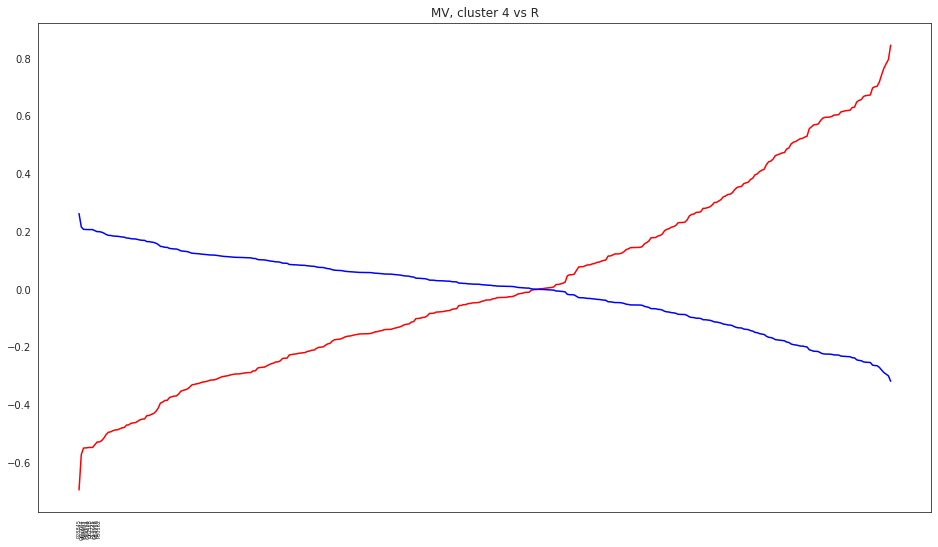

In [11]:
plt.figure(figsize=(16, 9))
plt.plot(diff1.tolist(), color='r', label='cluster {}'.format(c1))
plt.plot(diff2.tolist(), color='b', label='cluster {}'.format(c2))
#plt.xticks(range(len(diff1)), diff1.index,  rotation=90,fontsize=15)
plt.xticks(range(10), diff1.index[:10],  rotation=90,fontsize=5)
plt.title('{}, cluster {} vs {}'.format('MV', c1, c2))